In [1]:
## Import packages
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [2]:
## Data Importing functions

def import_client(filepath : str = "Data/client.csv") -> pd.DataFrame:
    """
    Function to import client dataset.
    """
    return pd.read_csv(filepath)

def import_invoice(filepath : str = "Data/invoice.csv") -> pd.DataFrame:
    """
    Function to import invoice dataset.
    """
    return pd.read_csv(filepath)

In [3]:
## Data Preprocessing functions

def convert_date(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converts date column to an integer representing 
    the number of days since the earliest date.
    *Column name 'date' is fixed for both datasets.
    """

    # Convert 'date' column to datetime
    df['date'] = pd.to_datetime(df['date'], dayfirst = True)
    
    # Find the earliest date
    earliest_date = df['date'].min()
    
    # Calculate the number of days since the earliest date
    df['date'] = (df['date'] - earliest_date).dt.days
    
    return df

def drop_duplicates(df : pd.DataFrame) -> pd.DataFrame:
    """
    Prints the result of a duplicate check.
    Drops duplicates if they exist.
    """
    if df.duplicated().any(): # Duplicates check
        print("Duplicates found! Cleaning them up...")
        df = df.drop_duplicates() # Drops duplicates
        df = df.reset_index(drop = True) # Resets indexes
    else:
        print("No duplicates found!")
    return df

def convert_to_categorical(
        df : pd.DataFrame,
        cols : list[str]
        ) -> pd.DataFrame:
    """
    Converts list of column names to categorical datatype.
    """
    df[cols] = df[cols].astype('category')
    return df


In [4]:
## Data Feature Engineering functions

def aggregate_invoice(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aggregate the invoice dataframe by id and generate features.
    Calculates sum, mean, max, and std for each consommation_level and date
    and counts number of invoices under each id.
    """
    df = df.groupby('id').agg({ # Aggregate by id
        # Calculate sum, mean, max, and std for each consm_level and date
        'consommation_level_1': ['sum', 'mean', 'max', 'std'],
        'consommation_level_2': ['sum', 'mean', 'max', 'std'],
        'consommation_level_3': ['sum', 'mean', 'max', 'std'],
        'consommation_level_4': ['sum', 'mean', 'max', 'std'],
        'date': ['sum', 'mean', 'max', 'std'],
        'counter_statue': 'count', # Count number of invoices
    }).reset_index()
    df.columns = [
        # Join by _ if more than 2 parts to the column name exists
        '_'.join(col).strip() if col[1] 
        else col[0] # Else use original name
        for col in df.columns.values # For each column name value
    ]
    return df

def manual_fix_names(
        df : pd.DataFrame,
        new_col_names : list[str]
        ) -> pd.DataFrame:
    """
    Manually sets the column names of a dataframe.
    """
    df.columns = new_col_names
    return df


In [5]:
## Data Joining functions

def merge(
        client_df : pd.DataFrame,
        invoice_df : pd.DataFrame,
        merge_by : str = "id"
        ) -> pd.DataFrame:
    """
    Merges two dataframes.
    Merges on 'id' column by default (for client and invoice).
    """
    merged_df = pd.merge(
        client_df, invoice_df, on = merge_by)
    return merged_df


In [6]:
## Dimensionality Reduction functions

def prep_dataframe(
        df : pd.DataFrame, 
        response_col_name : str,
        cat_col_names : list[str] = [],
        scale : bool = True,
        OHE : bool = True
        ) -> pd.DataFrame:
    """
    For scaling and one-hot encoding dataframe.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        response_col_name (str): Name of response column
        cat_col_names (list[str]): List of categorical column names to evaluate.
        scale (bool): Indicate if data should be scaled
        OHE (bool): Indicate if categorical variables should undergo One-Hot Encoding

    Returns:
        pd.DataFrame: A DataFrame with columns scaled/One-Hot Encoded
    """

    df = df.drop(columns = ['id']) 
    # Drop id column as it is not useful for predicting

    cat_col_names.remove('id') 
    # Remove 'id' as it no longer exists in dataframe

    if response_col_name in cat_col_names:
        cat_col_names.remove(response_col_name)
    # Exclude doing OHE on response column

    # Identify numerical columns 
    # by excluding categorical and response columns
    num_col_names = [
        col for col in df.columns 
        if col not in cat_col_names 
        and col != response_col_name
    ]

    y = df[response_col_name].values # Response column
    X_num = df[num_col_names].values # Numerical columns
    X_cat = df[cat_col_names].values # Categorical columns

    if scale:
        # Scale numerical features
        scaler = StandardScaler()
        X_num = scaler.fit_transform(X_num)

    if OHE:
        # One-hot encode categorical features
        encoder = OneHotEncoder(sparse_output = False, drop = 'first')  
        # drop = 'first' to avoid dummy variable trap
        X_cat = encoder.fit_transform(X_cat)
    
    # Combine the scaled numerical and encoded categorical features
    X_prep = pd.DataFrame(
        data = np.hstack((X_num, X_cat)),  # Horizontal stack to combine arrays
        columns = num_col_names + list(encoder.get_feature_names_out(cat_col_names))
    )

    # Create a new DataFrame including the response variable
    prep_df = pd.DataFrame(X_prep, columns = X_prep.columns)
    prep_df[response_col_name] = y

    return prep_df

def principal_component_analysis(
        df : pd.DataFrame, 
        response_col_name : str,
        cat_col_names : list[str] = [], 
        var : float = 0.95, 
        logs : bool = False
        ) -> pd.DataFrame:
    """
    For reducing the dimensions of a dataframe using PCA.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        response_col_name (str): Name of response column
        cat_col_names (list[str]): List of categorical column names to evaluate.
        var (float): Proportion of variance that should be preserved
        logs (bool): Indicate if logs should be printed

    Returns:
        pd.DataFrame: A DataFrame that has undergone PCA
    """

    if response_col_name in cat_col_names:
        cat_col_names.remove(response_col_name)
    # Exclude doing OHE on response column

    # Identify numerical columns 
    # by excluding categorical and response columns
    num_col_names = [
        col for col in df.columns 
        if col not in cat_col_names 
        and col != response_col_name
    ]

    y = df[response_col_name].values # Response column
    X_num = df[num_col_names].values # Numerical columns
    X_cat = df[cat_col_names].values # Categorical columns

    pca = PCA(n_components = var) 
    # Keep 'var' proportion of the variance : default 95%
    X_pca = pca.fit_transform(X_num) 

    pca_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]
    df_pca = pd.DataFrame(X_pca, columns = pca_columns)

    df_modified = pd.concat(
        [
            df_pca, 
            pd.DataFrame(X_cat, columns = cat_col_names), 
            pd.Series(y, name = response_col_name)
        ], 
        axis = 1)
    
    if logs:
        print(f"Number of components selected: {pca.n_components_}")
        print("Explained variance ratio for each component:", pca.explained_variance_ratio_)
        print("Cumulative explained variance:", pca.explained_variance_ratio_.cumsum())
        print("Final DataFrame with PCA applied to numeric columns:")
        print(df_modified.head())

    return df_modified

def filter_low_variance(
        df : pd.DataFrame, 
        response_col_name : str,
        threshold: float = 0.1
        ) -> pd.DataFrame:
    """
    Filter numeric columns based on a variance threshold.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        response_col_name (str): Name of response column
        threshold (float): The variance threshold for filtering columns.

    Returns:
        pd.DataFrame: A DataFrame with low variance numeric columns removed.
    """
    
    # Identify numerical columns 
    # by excluding response column
    num_col_names = [
        col for col in df.columns 
        if col != response_col_name
    ]

    # Calculate the variance for each numeric column
    variances = df[num_col_names].var()

    # Keep response column
    high_variance_cols = [response_col_name]

    # Filter columns with variance greater than the threshold : default 0.1
    cols_to_keep = variances[variances > threshold].index.tolist()
    high_variance_cols.extend(cols_to_keep)

    # Create a new DataFrame with only the selected columns
    filtered_df = df[high_variance_cols]

    return filtered_df


In [7]:
## Data Visualisation functions

def heatmap(
        df : pd.DataFrame,
        excluded_cols : list[str],
        annotate : bool = False
        ) -> None:
    """
    Plots a Correlation Heatmap.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        excluded_cols (list[str]): Columns to be excluded from the heatmap.
        annotate (float): To annotate the heatmap with correlation values.
    """
    
    # Identify desired columns 
    # by excluding undesired column
    col_names = [
        col for col in df.columns 
        if col not in excluded_cols
    ]

    X = df[col_names]

    corr_matrix = X.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        corr_matrix, annot = annotate, cmap = 'coolwarm', fmt = '.2f'
    )
    plt.title('Correlation Heatmap')
    plt.show()


In [8]:
## Data Balancing functions

def undersample_data(
        df: pd.DataFrame, 
        response_col_name: str, 
        proportion: float = 1
        ) -> pd.DataFrame:
    """
    Perform undersampling to balance the classes in the dataset based on a specified proportion.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        proportion (float): The desired ratio of minority to majority class samples (e.g., 0.5 for 1:2).

    Returns:
        pd.DataFrame: A balanced DataFrame with samples from both classes according to the specified proportion.
    """

    # Separate the majority and minority classes
    majority_class = df[response_col_name].value_counts().idxmax()
    minority_class = df[response_col_name].value_counts().idxmin()

    # Split the DataFrame into majority and minority
    df_majority = df[df[response_col_name] == majority_class]
    df_minority = df[df[response_col_name] == minority_class]

    # Calculate the number of samples to take from the majority class
    n_minority = len(df_minority)
    n_majority = int(n_minority / proportion)

    # Ensure we do not sample more than available
    n_majority = min(n_majority, len(df_majority))

    # Randomly sample from the majority class
    df_majority_sampled = df_majority.sample(n = n_majority, random_state = 42)

    # Combine the minority class with the undersampled majority class
    df_balanced = pd.concat([df_majority_sampled, df_minority])

    # Shuffle the resulting DataFrame
    df_balanced = df_balanced.sample(frac = 1, random_state = 42).reset_index(drop = True)

    return df_balanced

def smote(df : pd.DataFrame, response_col_name : str) -> pd.DataFrame:
    """
    Apply SMOTE to oversample the minority class in the dataset and return a balanced DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        
    Returns:
        pd.DataFrame: A DataFrame with balanced data using SMOTE.
    """
    y = df[response_col_name]
    X = df.drop(columns=[response_col_name])
    
    sm = SMOTE(random_state = 42)
    X_resampled, y_resampled = sm.fit_resample(X, y)
    
    df_resampled = pd.concat(
        [
            pd.DataFrame(X_resampled, columns = X.columns), 
            pd.DataFrame(y_resampled, columns = [response_col_name])
        ], 
        axis = 1)
    
    return df_resampled

def balance_data(
        df : pd.DataFrame, 
        response_col_name : str,
        prop_synthetic_data : float = 0.25
        ) -> pd.DataFrame:
    """
    Apply SMOTE and undersampling to return a balanced DataFrame.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        prop_synthetic_data (float): Proportion of final data that will be synthetic. (0 to 0.5)

    Returns:
        pd.DataFrame: A DataFrame with balanced data.
    """

    if prop_synthetic_data < 0:
        prop_synthetic_data = 0
    elif prop_synthetic_data >= 0.5:
        prop_synthetic_data = 0.499

    df = undersample_data(
        df = df, 
        response_col_name = response_col_name,
        proportion = (1 - 2 * prop_synthetic_data))
    
    df = smote(df, response_col_name = response_col_name)

    return df

In [9]:
## Feature Importance function

def get_feature_importance(
        df : pd.DataFrame, 
        response_col_name : str,
        excluded_cols : list[str] = []
        ) -> None:
    """
    Uses Random Forests to identify the most important features in predicting response.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the data.
        response_col_name (str): The name of the target column (class label).
        excluded_cols (list[str]): Columns to be excluded from the heatmap.
        scale (bool): To scale the dataset or not.
    """

    col_names = [
        col for col in df.columns 
        if col not in excluded_cols 
        and col != response_col_name
    ]

    X = df[col_names]
    y = df[response_col_name]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3, random_state = 42, stratify = y)
    
    # Initialised the Random Forest Classifier with class weight to handle class imbalance
    rf_model = RandomForestClassifier(class_weight = 'balanced', random_state = 42)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Feature importance
    feature_importances = rf_model.feature_importances_

    # Create a DataFrame for feature importance
    features = X.columns  # Get feature names
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

    # Sort features by importance
    importance_df = importance_df.sort_values(by = 'Importance', ascending = False)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='b')
    plt.gca().invert_yaxis()  # Highest importance at the top
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in Random Forest')
    plt.show()


In [10]:
## Define main workflow

def main(): 
    client_df = import_client()
    invoice_df = import_invoice()
    client_df = convert_date(client_df) # Convert date cols
    invoice_df = convert_date(invoice_df)
    client_df = drop_duplicates(client_df) # Drop duplicates rows
    invoice_df = drop_duplicates(invoice_df)
    categorical_column_names = ['region', 'dis', 'id', 'catg', 'target']
    client_df = convert_to_categorical( # Convert categorical cols
        client_df, cols = categorical_column_names
        )
    invoice_df = aggregate_invoice(invoice_df) # Aggregate invoices
    invoice_df = manual_fix_names( # Fix column names manually
        invoice_df, 
        new_col_names = [
            'id', 
            'cons_level_1_sum', 'cons_level_1_mean', 
            'cons_level_1_max', 'cons_level_1_std',
            'cons_level_2_sum', 'cons_level_2_mean', 
            'cons_level_2_max', 'cons_level_2_std',
            'cons_level_3_sum', 'cons_level_3_mean', 
            'cons_level_3_max', 'cons_level_3_std',
            'cons_level_4_sum', 'cons_level_4_mean', 
            'cons_level_4_max', 'cons_level_4_std',
            'date_sum', 'date_mean', 'date_max', 'date_std',
            'num_invoices'
            ]
        )
    df = merge(client_df = client_df, invoice_df = invoice_df) # Merge
    df = prep_dataframe( # Prep for PCA
        df = df,
        response_col_name = 'target',
        cat_col_names = categorical_column_names
    )
    heatmap( # Do Heatmap for pre-reduced data
        df, excluded_cols = categorical_column_names)
    # Get feature importance for pre-reduced data
    get_feature_importance(df, 'target', categorical_column_names)
    df = principal_component_analysis( # Do PCA
        df = df,
        response_col_name = 'target'
    )
    # Do Low Variance Filter
    df = filter_low_variance(df, response_col_name = 'target')
    heatmap( # Do Heatmap for post-reduced data
        df, excluded_cols = categorical_column_names, annotate = True)
    # Get feature importance for post-reduced data
    get_feature_importance(df, 'target')
    # Print pre-balancing proportion of response
    print(df['target'].value_counts()) 
    df = balance_data( # Do balancing 
        df = df, 
        response_col_name = 'target', 
        prop_synthetic_data = 0.4 # Final proportion of synthetic data
        ) 
    # Print post-balancing proportion of response
    print(df['target'].value_counts()) 
    print(df.head())


No duplicates found!
Duplicates found! Cleaning them up...


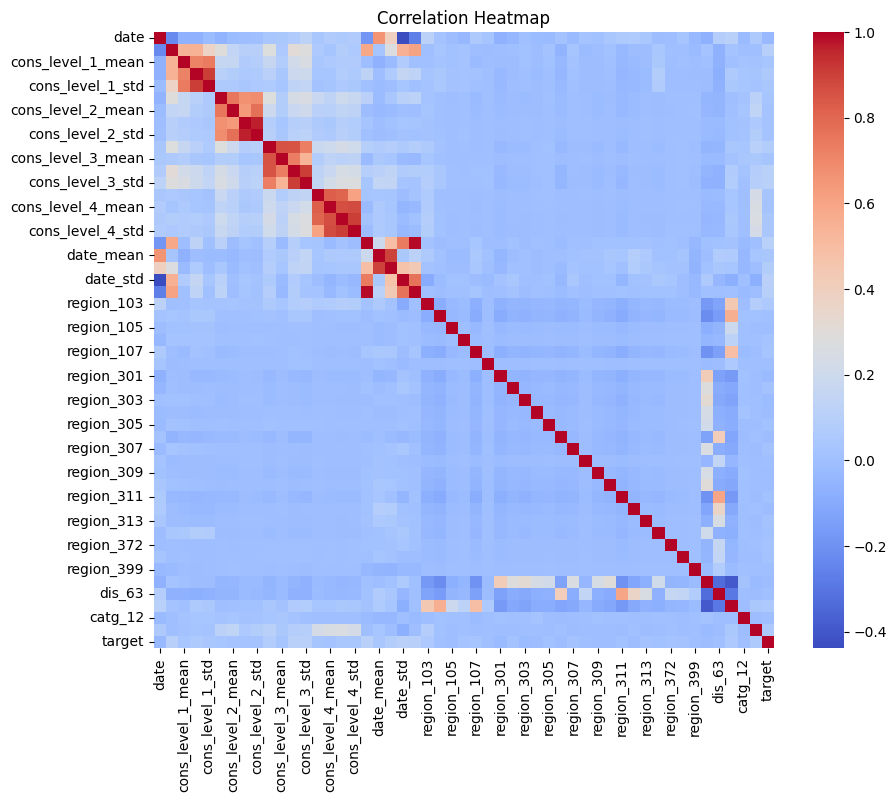

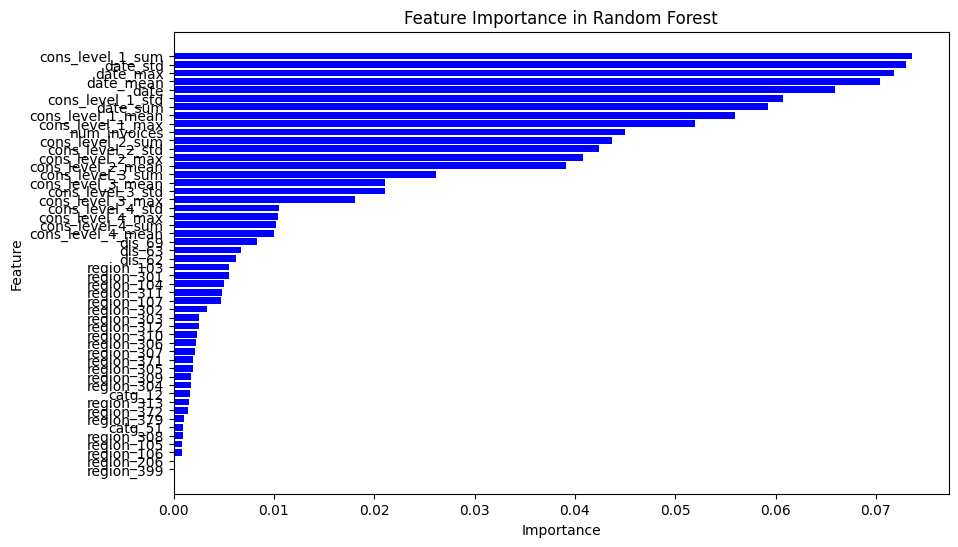

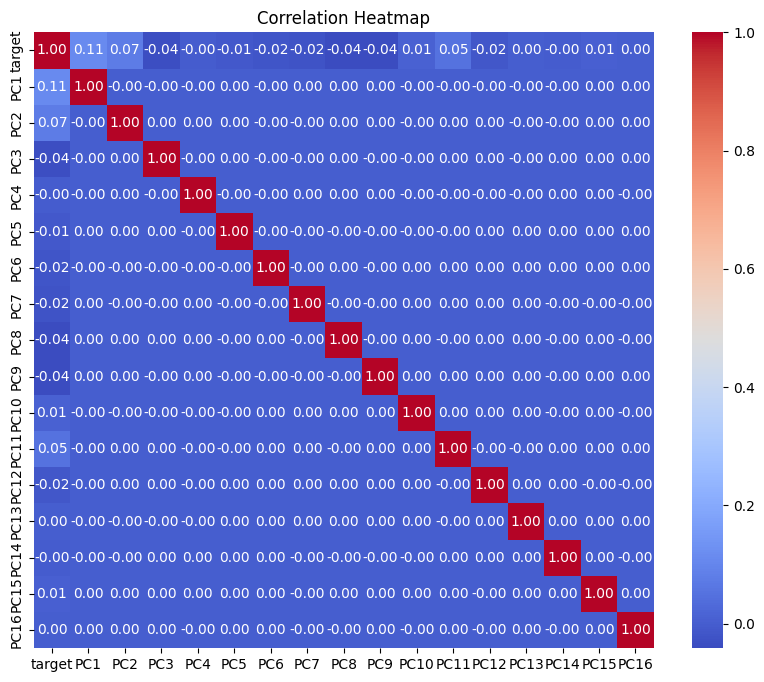

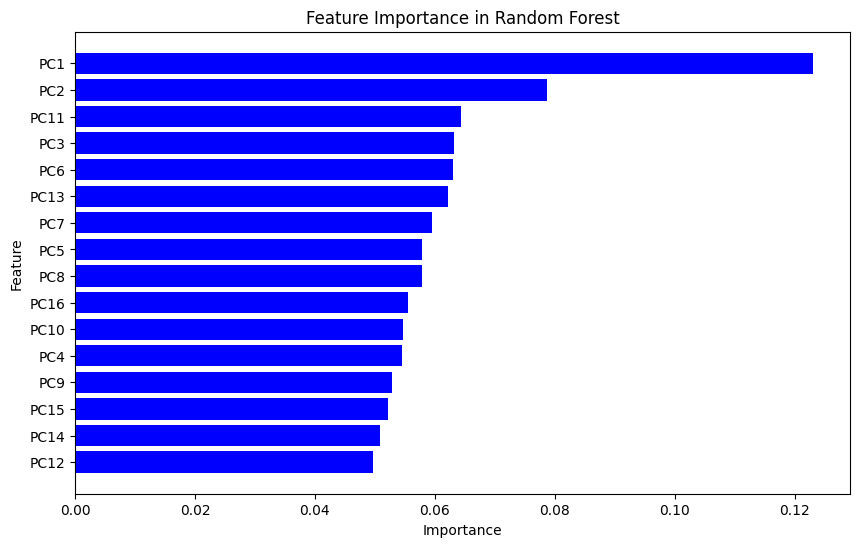

target
0    20576
1     1076
Name: count, dtype: int64
target
0    5380
1    5380
Name: count, dtype: int64
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.313846  1.798580 -0.504239 -1.341465  0.278369 -1.478695  0.680652   
1  0.358223 -0.832108 -0.034217  1.080296 -0.858422  1.413999 -0.200257   
2 -1.216144 -0.884816 -0.509105 -0.426303 -0.990615  0.986792  0.266670   
3 -0.039088  1.365297 -0.331501 -0.789622  0.158097 -0.944652  0.314758   
4 -1.445440 -1.640353 -0.361803 -0.028223 -1.127603  1.511789  0.089378   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.825650  0.289200  0.184575  0.178209  0.516270 -0.194868 -0.234672   
1 -0.601431  0.142532 -0.349596  0.097097  0.666427 -0.212606 -0.172135   
2  0.037183  0.117513  0.196744  0.092343  0.031090  0.831808  0.292165   
3 -0.460765 -0.155372  0.381961  0.606867 -0.833744 -0.365964 -0.157098   
4 -0.179459  0.427180 -0.213680 -0.198707  0.575190 -0.437308  0.2

In [11]:
## Run to execute main workflow

main()
